# Multistage Hypersolver pre-train

In [1]:
%load_ext autoreload
%autoreload 2

import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import pi as π

import sys; sys.path.append(2*'../') # go n dirs back
from src import *

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler
from torchdyn.numerics.solvers import Midpoint, SolverTemplate
from torchdyn.numerics.hypersolvers import HyperMidpoint

device = 'cpu' # feel free to change!

In [2]:
# The controller is a simple MLP with one hidden layer with bounded output
class NeuralController(nn.Module):
    def __init__(self, model, u_min=-20, u_max=20):
        super().__init__()
        self.model = model
        self.u_min, self.u_max = u_min, u_max
        
    def forward(self, t, x):
        x = self.model(x)
        return torch.clamp(x, self.u_min, self.u_max)

model = nn.Sequential(nn.Linear(4, 32), nn.Tanh(), nn.Linear(32, 1)).to(device)
u = NeuralController(model) 
for p in u.model[-1].parameters(): torch.nn.init.zeros_(p)

# Controlled system
sys = CartPole(u).to(device)

## Generate distribution

We generate a distribution $\xi(x,u)$ to train the hypersolver

In [3]:

# Loss function declaration
x_star = torch.Tensor([0. , 0.,  0., 0.]).to(device)
cost_func = IntegralCost(x_star)

# Time span
dt = 0.01
t0, tf = 0, 5 # initial and final time for controlling the system
steps = int((tf - t0)/dt) + 1 # so we have a time step of 0.2s
t_span = torch.linspace(t0, tf, steps).to(device)

# Initial distribution
x0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0, -x0, -x0]), torch.Tensor([x0, x0, x0, x0]))

In [4]:
# We consider the controller fixed during each solver step
class RandConstController(nn.Module):
    def __init__(self):
        super().__init__()
        self.u0 = torch.Tensor(1024, 1).uniform_(-10,10).to(device)
        
    def forward(self, t, x):
        return self.u0
    
# Save previously learned controller
u_no_hypersolver = sys.u
sys.u = RandConstController() # modify controller for training

## Plotting trajectories

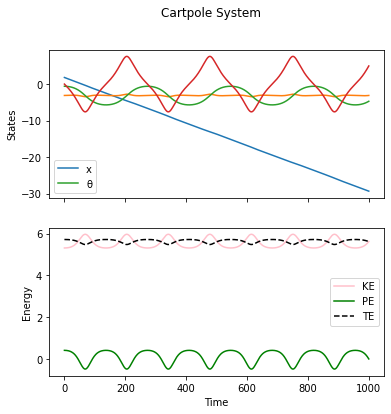

In [5]:
sys.u.u0 = torch.zeros(1) # no controller

t_span = torch.linspace(0, 10, 1001)
x_init = init_dist.sample((1,))
_, traj = odeint(sys._dynamics, x_init, t_span, solver='rk4')
traj = traj.squeeze()


def plot_traj_system(sys, traj):
    KE, PE = sys.kinetic_energy(traj), sys.potential_energy(traj)
    TE = KE + PE

    fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
    fig.suptitle('Cartpole System')
    ax[0].plot(traj[:, 0], label='x')
    ax[0].plot(traj[:, 1], label='dx')
    ax[0].plot(traj[:, 2], label='θ')
    ax[0].plot(traj[:, 3], label='dθ')

    ax[0].set_ylabel('States')
    ax[0].legend()

    handles, labels = ax[0].get_legend_handles_labels()
    _ = ax[0].legend(handles[::2], labels[::2])

    ax[1].plot(KE, label='KE', c='pink')
    ax[1].plot(PE, label='PE', c='green')
    ax[1].plot(TE, label='TE', ls='--', c='black')
    ax[1].set_ylabel('Energy')
    ax[1].set_xlabel('Time')
    ax[1].legend()
    plt.show()

plot_traj_system(sys, traj.detach())

In [6]:
class MultiStageHypersolver(SolverTemplate):
    """
    Explicit multistage ODE stepper: inner stage is a vector field corrector
    while the outer stage is a residual approximator of the ODE solver
    """
    def __init__(self, inner_stage: nn.Module, outer_stage: nn.Module,
                       base_solver=Midpoint, dtype=torch.float32):
        super().__init__(order=base_solver().order)
        self.dtype = dtype
        self.stepping_class = 'fixed'
        self.base_solver = base_solver
        self.inner_stage = inner_stage
        self.outer_stage = outer_stage

    def step(self, f, x, t, dt, k1=None):
        # Correct vector field with inner stage and propagate
        self.vector_field = f
        _, _x_sol, _ = self.base_solver().step(self.corrected_vector_field, x, t, dt, k1=k1)
        # Residual correction with outer stage
        x_sol = _x_sol + dt**self.base_solver().order * self.outer_stage(t, f(t, x))
        return _, x_sol, _ 

    def corrected_vector_field(self, t, x):
        return self.vector_field(t, x) + self.inner_stage(t, x)


class HyperNetwork(nn.Module):
    """Simple hypernetwork using as input the current state, vector field and controller"""
    def __init__(self, net, sys):
        super().__init__()
        self.net = net
        self.sys = sys
    
    def forward(self, t, x):
        xfu = torch.cat([x, self.sys.cur_f, self.sys.cur_u], -1)
        return self.net(xfu)
        

In [7]:
# System we have
sys = CartPole(RandConstController())

# Real system
sys_nominal = CartPole(RandConstController())
sys_nominal.frictioncart = 0.1
sys_nominal.frictionpole = 0.03



## Training loop
We train via stochastic exploration
(This will take some time)

In [13]:
# Initial distribution
x0 = 2*π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0, -x0, -x0]), torch.Tensor([x0, x0, x0, x0]))
u_min, u_max = -30, 30

# base_net_inner = nn.Sequential(nn.Linear(9, 32), nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 4))

hdim = 32
base_net_inner = nn.Sequential(nn.Linear(9, hdim), Snake(hdim), nn.Linear(hdim, hdim), Snake(hdim), nn.Linear(hdim, 4))
base_net_outer = nn.Sequential(nn.Linear(9, hdim), Snake(hdim), nn.Linear(hdim, hdim), Snake(hdim), nn.Linear(hdim, 4))
# base_net_inner = nn.Sequential(nn.Linear(9, 32), nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 4))
# base_net_outer = nn.Sequential(nn.Linear(9, 32), nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 4))

inner_stage = HyperNetwork(base_net_inner, sys)
outer_stage = HyperNetwork(base_net_outer, sys)

multistagehs = MultiStageHypersolver(inner_stage, outer_stage, base_solver=Midpoint)
opt = torch.optim.Adam(multistagehs.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[3e5, 4e5], gamma=0.1)
# opt = torch.optim.Adam(multistagehs.inner_stage.parameters(), lr=1e-3)

loss_func = nn.MSELoss()
epochs = 50000
bs = 128
dt = 0.05
span = torch.linspace(0, dt, 2)
losses = []
# sys._use_xfu=True

# with trange(0, epochs, desc="Epochs") as stepx:
#     for i in stepx:    
for i in range(epochs):
    x0 = init_dist.sample((bs,)).to(device)
    val = torch.Tensor(bs, 1).uniform_(u_min, u_max).to(device)
    sys.u.u0 = val
    sys_nominal.u.u0 = val
    
    # Compute residuals
    _, sol_gt = odeint(sys_nominal._dynamics, x0, span, solver='rk4')[-1]
    _, sol_hs = odeint(sys._dynamics, x0, span, solver=multistagehs)[-1]

    # f = sys._dynamics(0, x0)
    # sys.cur_f = f
    # g = hypernet(0, x0)
    # half_state_dim = g.shape[-1] ii// 2
    # g1, g2 = g[..., :half_state_dim], g[..., half_state_dim:]
    # sol = x0 + dt* (f + g1) + dt**2*g2
    loss = loss_func(sol_gt, sol_hs)

    # Optimization step
    loss.backward(); opt.step(); opt.zero_grad(); scheduler.step()
    print(f'Step: {i}, Residual loss: {loss:.8f}', end='\r')
    losses.append(loss.detach().cpu().item())
        # loss_val = loss.detach().cpu().item()
        # stepx.set_postfix({'Loss':loss_val})
        # losses.append(loss_val)

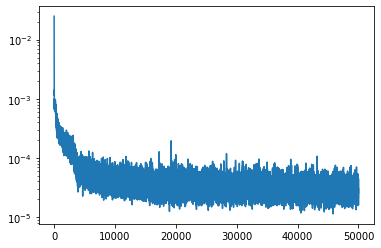

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set_yscale('log')

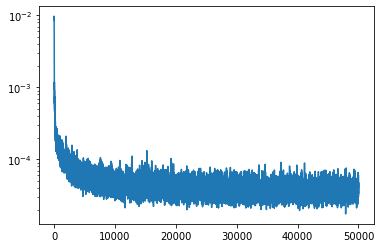

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses)
ax.set_yscale('log')

In [15]:
# Save the model
torch.save(multistagehs, 'saved_models/hs_multistage_joint_snake.pt')

/home/botu/.local/lib/python3.8/site-packages/torchdyn/numerics/odeint.py:82: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


Text(0.5, 0.98, 'Constant Controller Trajectories')

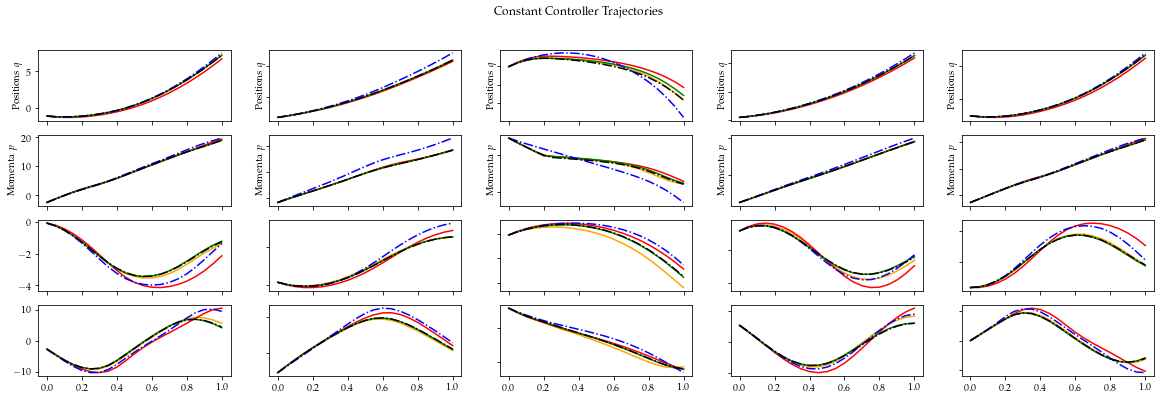

In [ ]:
from math import pi as π

# Sample and plot some trajectories
x0 = π # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x0, -x0, -x0, -x0]), torch.Tensor([x0, x0, x0, x0]))
x0 = init_dist.sample((10000,)).to(device)
val = torch.Tensor(10000, 1).uniform_(-30,30).to(device)
sys.u.u0 = val
sys_nominal.u.u0 = val

Tf = 1
t_span = torch.linspace(0, Tf, int(Tf/dt)+1).to(device)

with torch.no_grad():
    _, traj_euler = odeint(sys_nominal._dynamics, x0, t_span, solver='euler')
    # _, traj_hyper = odeint(sys._dynamics, x0, t_span, solver=hypersolver)
    # sys.multistage = True
    # sys.hypersolve = hypernet

    # traj_hyper = sys(x0, t_span)
    _, traj_hyper = odeint(sys._dynamics, x0, t_span, solver=multistagehs)

    _, traj_mp = odeint(sys_nominal._dynamics, x0, t_span, solver='midpoint')
    _, traj_gt_wrong = odeint(sys._dynamics, x0, t_span, solver='rk4', atol=1e-4, rtol=1e-4)
    _, traj_gt = odeint(sys_nominal._dynamics, x0, t_span, solver='rk4', atol=1e-4, rtol=1e-4)
    traj_euler = traj_euler.detach().cpu(); traj_hyper = traj_hyper.detach().cpu(); traj_gt = traj_gt.detach().cpu()
    traj_mp = traj_mp.detach().cpu(); traj_gt_wrong = traj_gt_wrong.detach().cpu()
    t_span = t_span.cpu()

fig, axs = plt.subplots(4, 5, figsize=(20,6))

for i in range(5):
    for j in range(4):
        axs[j, i].plot(t_span, traj_hyper[:,i,j], 'orange')
        axs[j, i].plot(t_span, traj_euler[:,i,j], 'r')
        axs[j, i].plot(t_span, traj_mp[:,i,j], 'green')
        axs[j, i].plot(t_span, traj_gt_wrong[:,i,j], 'b-.')
        axs[j, i].plot(t_span, traj_gt[:,i,j], 'k-.')
#         axs[j, i].legend(['Euler', 'HyperEuler', 'Midpoint', 'RK4', 'Ground Truth'])
        axs[j, i].label_outer()
    axs[0, i].set_ylabel(r'Positions $q$'); axs[1, i].set_ylabel(r'Momenta $p$')

fig.suptitle('Constant Controller Trajectories')

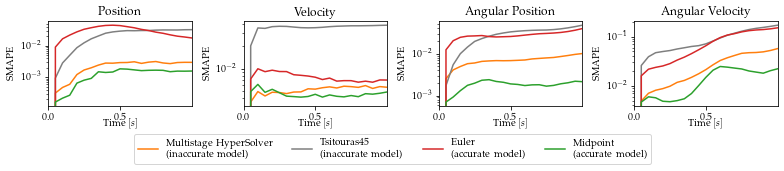

In [ ]:
# Error analysis
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

err_euler = smape(traj_gt, traj_euler).detach().cpu();  err_hyper = smape(traj_gt, traj_hyper).detach().cpu()
err_mp, err_gt_wrong = smape(traj_gt, traj_mp).detach().cpu(), smape(traj_gt, traj_gt_wrong).detach().cpu()
mean_euler, std_euler = err_euler.mean(1), err_euler.std(1)
mean_hyper, std_hyper = err_hyper.mean(1), err_hyper.std(1)
mean_mp, std_mp = err_mp.mean(1), err_mp.std(1)
mean_gt_wrong, std_gt_wrong = err_gt_wrong.mean(1), err_gt_wrong.std(1)


fig, axs = plt.subplots(1, 4, figsize=(11,2))
# fig = plt.figure(figsize=(16,5))
# ax = fig.add_subplot(1,2,1)
titles = ['Position', 'Velocity', 'Angular Position', 'Angular Velocity']

alpha = .1
for i in range(4):
    axs[i].plot(t_span, mean_hyper[:,i], 'tab:orange', label='Multistage HyperSolver\n (inaccurate model)')
    axs[i].plot(t_span, mean_gt_wrong[:,i], 'tab:grey', label='Tsitouras45 \n(inaccurate model)')
    axs[i].plot(t_span, mean_euler[:,i], 'tab:red', label='Euler \n(accurate model)')
    axs[i].plot(t_span, mean_mp[:,i], 'tab:green', label='Midpoint \n (accurate model)')


    # axs[i].fill_between(t_span, mean_euler[:,i]-std_euler[:,i], mean_euler[:,i]+std_euler[:,i], alpha=alpha, color='tab:')
    # axs[i].fill_between(t_span, mean_hyper[:,i]-std_hyper[:,i], mean_hyper[:,i]+std_hyper[:,i], alpha=alpha, color='orange')
    # axs[i].fill_between(t_span, mean_mp[:,i]-std_mp[:,i], mean_mp[:,i]+std_mp[:,i], alpha=alpha, color='green')
    # axs[i].fill_between(t_span, mean_gt_wrong[:,i]-std_gt_wrong[:,i], mean_gt_wrong[:,i]+std_gt_wrong[:,i], alpha=alpha, color='blue')
    axs[i].set_yscale('log')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel(f'Time $[s]$', labelpad=-4)
    axs[i].set_ylabel(f'SMAPE')
    axs[i].set_xticks([0, 0.5])
    axs[i].set_xlim(0, 1)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,-0.2))

plt.tight_layout()
